# Pick and Place Tutorial

We'll show pick and place demo on a panda robot.  
You can understand quickly by referencing [MoveIt Grasps tutorials](https://ros-planning.github.io/moveit_tutorials/doc/moveit_grasps/moveit_grasps_tutorial.html).

In [1]:
import numpy as np
import sys, os
import trimesh
%matplotlib inline

pykin_path = os.path.dirname(os.getcwd())
sys.path.append(pykin_path)

from pykin.robots.single_arm import SingleArm
from pykin.kinematics.transform import Transform
from pykin.collision.collision_manager import CollisionManager
from pykin.tasks.grasp import GraspManager, GraspStatus
import pykin.utils.plot_utils as plt

In [2]:
file_path = '../asset/urdf/panda/panda.urdf'
robot = SingleArm(file_path, Transform(rot=[0.0, 0.0, 0.0], pos=[0, 0, 0.913]))
robot.setup_link_name(eef_name="panda_right_hand")

init_qpos = [0.0, np.pi/6, 0.0, -np.pi*12/24, 0.0, np.pi*5/8,0.0]
fk = robot.forward_kin(np.array(init_qpos))

### Set up CollisionManager for checking robot self-collision

In [3]:
mesh_path = pykin_path+"/asset/urdf/panda/"
c_manager = CollisionManager(mesh_path)
c_manager.setup_robot_collision(robot, fk)

### Set up CollisionManager for checking between robot and objects

In [4]:
o_manager = CollisionManager()
obs_pos1 = Transform(pos=np.array([0.6, 0.2, 0.77]), rot=np.array([0, np.pi/2, np.pi/2]))
obs_pos2 = Transform(pos=np.array([0.6, -0.2, 0.77]), rot=np.array([0, np.pi/2, 0]))
obs_pos3 = Transform(pos=np.array([0.4, 0.24, 0.0]))

obj_mesh1 = trimesh.load(pykin_path+'/asset/objects/meshes/square_box.stl')
obj_mesh2 = trimesh.load(pykin_path+'/asset/objects/meshes/box_goal.stl')
obj_mesh3 = trimesh.load(pykin_path+'/asset/objects/meshes/custom_table.stl')

obj_mesh1.apply_scale(0.001)
obj_mesh2.apply_scale(0.001)
obj_mesh3.apply_scale(0.01)

o_manager.add_object("can", gtype="mesh", gparam=obj_mesh1, transform=obs_pos1.h_mat)
o_manager.add_object("box", gtype="mesh", gparam=obj_mesh2, transform=obs_pos2.h_mat)
o_manager.add_object("table", gtype="mesh", gparam=obj_mesh3, transform=obs_pos3.h_mat)

### Set configurations about gripper info
- gripper_names: element names that make up the gripper  
- gripper_max_width: max distance between left finger and right finger
- gripper_max_depth: length of finger
- tcp_position: tcp(tool center point) position

In [5]:
configures = {}
configures["gripper_names"] = ["right_gripper", "leftfinger", "rightfinger", "tcp"]
configures["gripper_max_width"] = 0.08
configures["gripper_max_depth"] = 0.035
configures["tcp_position"] = np.array([0, 0, 0.097])

### Use GraspManager
- retreat_distance: distance used to obtain pre/post grasp pose and pre/post release poses 
- release_distance: distance to how far apart an object is to be placed

In [6]:
grasp_man = GraspManager(
    robot, 
    c_manager, 
    o_manager, 
    mesh_path,    
    retreat_distance=0.15,
    release_distance=0.01,
    **configures)

### Step 1. generate grasp poses

The generate_grasps method is to generate grasp poses.  
- limit_angle: angle to satisfy force closure
- num_grasp: number of sampling contact points
- n_trials: parameter to obtain grasp poses by 360/n_trials angle around a pair of contact points

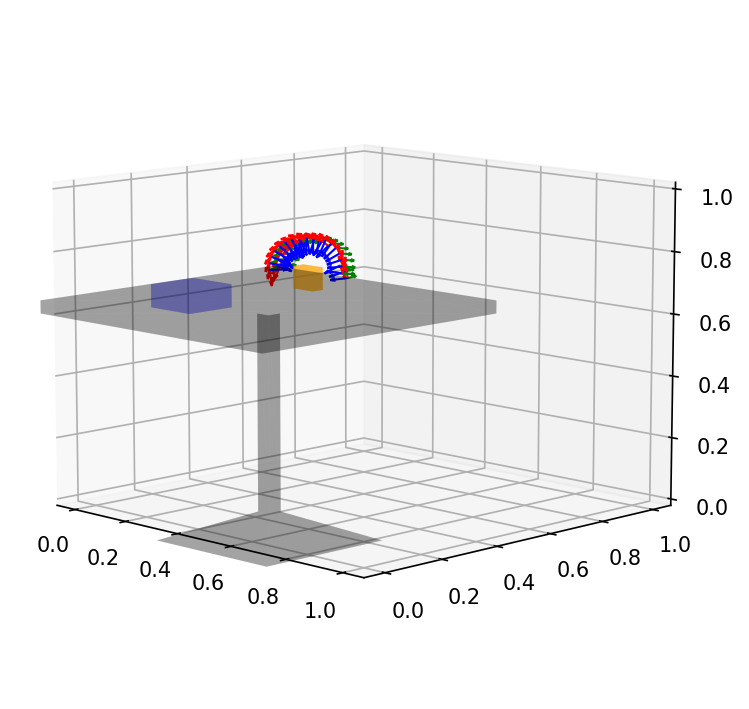

In [7]:
fig, ax = plt.init_3d_figure(figsize=(8,6), dpi=150)
ax.view_init(10, -45)
plt.plot_mesh(ax=ax, mesh=obj_mesh1, A2B=obs_pos1.h_mat, alpha=0.5, color='orange')
plt.plot_mesh(ax=ax, mesh=obj_mesh2, A2B=obs_pos2.h_mat, alpha=0.2, color='blue')
plt.plot_mesh(ax=ax, mesh=obj_mesh3, A2B=obs_pos3.h_mat, alpha=0.2)
grasp_poses = grasp_man.generate_grasps(obj_mesh1, obs_pos1.h_mat, limit_angle=0.5, num_grasp=1, n_trials=30)

for i, (eef_pose, gripper) in enumerate(grasp_poses):
    grasp_man.visualize_axis(ax, eef_pose, axis=[1,1,1], scale=0.05)


### Step 2. Get grasp pose

The get_grasp_pose method is to get pre grasp, grasp and post prasp pose. 

A grasp pose that exists ik solution and satisfies collision free is obtained.

When the grasp pose is found, an INFO message is displayed.  
You can see blue gripper to grasp yellow object.

Iterators : 14
WorkingTime[inverse_kinematics]: 0.0116 sec

Iterators : 14
WorkingTime[inverse_kinematics]: 0.0144 sec

Iterators : 282
WorkingTime[inverse_kinematics]: 0.2008 sec

Iterators : 500
WorkingTime[inverse_kinematics]: 0.3227 sec



[INFO] [Grasp]: Success to get Grasp pose.



Iterators : 498
WorkingTime[inverse_kinematics]: 0.3788 sec

Iterators : 9
WorkingTime[inverse_kinematics]: 0.0127 sec

Iterators : 15
WorkingTime[inverse_kinematics]: 0.0144 sec

Iterators : 15
WorkingTime[inverse_kinematics]: 0.0147 sec



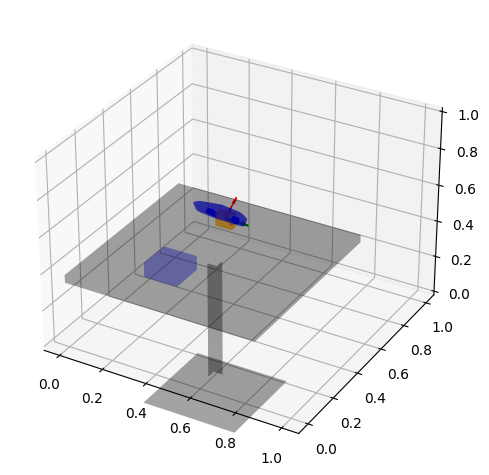

In [8]:
fig, ax = plt.init_3d_figure(figsize=(8,6), dpi=100)
plt.plot_mesh(ax=ax, mesh=obj_mesh1, A2B=obs_pos1.h_mat, alpha=0.5, color='orange')
plt.plot_mesh(ax=ax, mesh=obj_mesh2, A2B=obs_pos2.h_mat, alpha=0.2, color='blue')
plt.plot_mesh(ax=ax, mesh=obj_mesh3, A2B=obs_pos3.h_mat, alpha=0.2)

grasp_pose = grasp_man.get_grasp_pose(obj_mesh=obj_mesh1, obj_pose=obs_pos1.h_mat, limit_angle=0.1, num_grasp=10, n_trials=10)

grasp_man.visualize_axis(ax, grasp_man.tcp_pose, axis=[1,1,1], scale=0.05)
gripper = grasp_man.get_gripper_transformed(grasp_man.tcp_pose)
grasp_man.visualize_gripper(ax, gripper, alpha=0.5, color='blue')
grasp_man.visualize_axis(ax, grasp_man.tcp_pose, axis=[1,1,1], scale=0.1)

### Step 3. Get grasp waypoints

The get_grasp_waypoints method is to get grasp waypoints.  

grasp waypoints include pre grasp, grasp and post prasp pose.  

waypoints's type is OrderedDict. Key is GraspStatus enum class and value is pose related grasp status.  

You can see blue gripper in pre grasp pose and grasp pose.

[INFO] [Grasp]: Success to get Grasp pose.



Iterators : 23
WorkingTime[inverse_kinematics]: 0.0207 sec

Iterators : 21
WorkingTime[inverse_kinematics]: 0.0263 sec

Iterators : 20
WorkingTime[inverse_kinematics]: 0.0155 sec

Iterators : 20
WorkingTime[inverse_kinematics]: 0.0157 sec



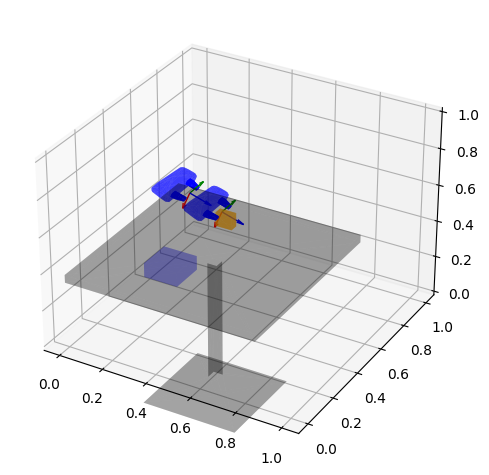

In [9]:
fig, ax = plt.init_3d_figure(figsize=(8,6), dpi=100)
plt.plot_mesh(ax=ax, mesh=obj_mesh1, A2B=obs_pos1.h_mat, alpha=0.5, color='orange')
plt.plot_mesh(ax=ax, mesh=obj_mesh2, A2B=obs_pos2.h_mat, alpha=0.2, color='blue')
plt.plot_mesh(ax=ax, mesh=obj_mesh3, A2B=obs_pos3.h_mat, alpha=0.2)

waypoints = grasp_man.get_grasp_waypoints(obj_mesh=obj_mesh1, obj_pose=obs_pos1.h_mat, limit_angle=0.1, num_grasp=10, n_trials=10)
pre_grasp_pose = waypoints[GraspStatus.pre_grasp_pose]
grasp_pose = waypoints[GraspStatus.grasp_pose]

gripper = grasp_man.get_gripper_transformed(pre_grasp_pose, is_tcp=False)
grasp_man.visualize_gripper(ax, gripper, alpha=0.5, color='blue')
grasp_man.visualize_axis(ax, grasp_man.get_tcp_h_mat_from_eef(pre_grasp_pose), axis=[1,1,1], scale=0.1)
gripper = grasp_man.get_gripper_transformed(grasp_pose, is_tcp=False)
grasp_man.visualize_gripper(ax, gripper, alpha=0.5, color='blue')
grasp_man.visualize_axis(ax, grasp_man.get_tcp_h_mat_from_eef(grasp_pose), axis=[1,1,1], scale=0.1)
plt.show_figure()

### Step 4. Sampling surface points of two objects

From now on, the blue object will be called Object A and the orange object will be called Object B.

The generate_points_on_support method is to generate surface points on object A.

The generate_points_for_support method is to generate surface points on object B.

The points corresponding to the green surface normal vector must be matched with the red surface normal vector points, and the direction of the green sufrace normal vector must be in the negative z-axis direction.

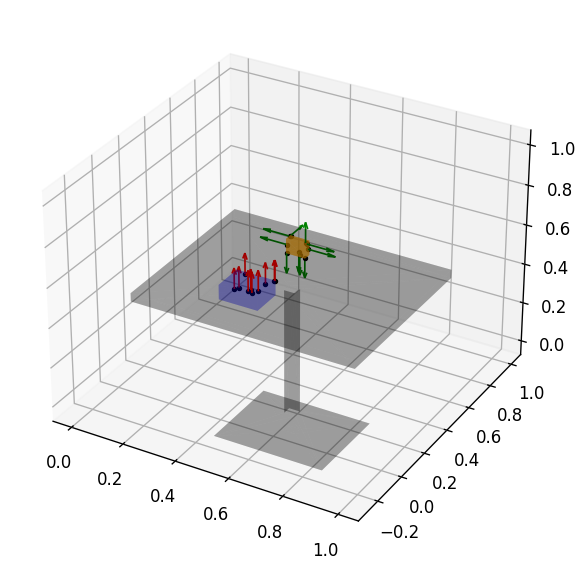

In [10]:
fig, ax = plt.init_3d_figure(figsize=(10,6), dpi=120)
plt.plot_mesh(ax=ax, mesh=obj_mesh1, A2B=obs_pos1.h_mat, alpha=0.5, color='orange')
plt.plot_mesh(ax=ax, mesh=obj_mesh2, A2B=obs_pos2.h_mat, alpha=0.2, color='blue')
plt.plot_mesh(ax=ax, mesh=obj_mesh3, A2B=obs_pos3.h_mat, alpha=0.2)
for point, normal in grasp_man.generate_points_on_support(obj_mesh2, obs_pos2.h_mat, n_samples=10):
    plt.plot_vertices(ax, point)
    plt.plot_normal_vector(ax, point, normal, scale=0.1)

for point, normal in grasp_man.generate_points_for_support(obj_mesh1, obs_pos1.h_mat, n_samples=10):
    plt.plot_vertices(ax, point)
    plt.plot_normal_vector(ax, point, normal, scale=0.1, edgecolor="green")
plt.show_figure()

### Step 5. Get release waypoints

The get_release_waypoints method is to get release waypoints.  
release waypoints include pre release, release and post release pose.  

In [11]:
grasp_waypoints = grasp_man.get_grasp_waypoints(obj_mesh=obj_mesh1, obj_pose=obs_pos1.h_mat, limit_angle=0.1, num_grasp=10, n_trials=10)
release_waypoints = grasp_man.get_release_waypoints(
    obj_mesh_on_sup=obj_mesh2, 
    obj_pose_on_sup=obs_pos2.h_mat, 
    n_samples_on_sup=10, 
    obj_mesh_for_sup=obj_mesh1, 
    obj_pose_for_sup=obs_pos1.h_mat, 
    n_samples_for_sup=10, 
    n_trials=10)

pre_grasp_pose = grasp_waypoints[GraspStatus.pre_grasp_pose]
grasp_pose = grasp_waypoints[GraspStatus.grasp_pose]

pre_release_pose = release_waypoints[GraspStatus.pre_release_pose]
release_pose = release_waypoints[GraspStatus.release_pose]

Iterators : 17
WorkingTime[inverse_kinematics]: 0.0141 sec



[INFO] [Grasp]: Success to get Grasp pose.

[INFO] [Grasp]: Success to get Release pose.



Iterators : 500
WorkingTime[inverse_kinematics]: 0.3220 sec

Iterators : 26
WorkingTime[inverse_kinematics]: 0.0268 sec

Iterators : 17
WorkingTime[inverse_kinematics]: 0.0140 sec

Iterators : 24
WorkingTime[inverse_kinematics]: 0.0188 sec

Iterators : 29
WorkingTime[inverse_kinematics]: 0.0190 sec

Iterators : 13
WorkingTime[inverse_kinematics]: 0.0121 sec

Iterators : 20
WorkingTime[inverse_kinematics]: 0.0157 sec



In fact, you can get waypoints at once by using the get_grasp_waypoints and get_release_waypoints methods.

In [12]:
for status, pose in grasp_waypoints.items():
    print(status, pose)

for status, pose in release_waypoints.items():
    print(status, pose)

GraspStatus.pre_grasp_pose [[ 0.05673283 -0.99609742 -0.06761156  0.61670005]
 [-0.85546761 -0.0834145   0.51109411  0.07073245]
 [-0.51473931  0.02884368 -0.85686142  1.00440928]
 [ 0.          0.          0.          1.        ]]
GraspStatus.grasp_pose [[ 0.05673283 -0.99609742 -0.06761156  0.60655832]
 [-0.85546761 -0.0834145   0.51109411  0.14739656]
 [-0.51473931  0.02884368 -0.85686142  0.87588007]
 [ 0.          0.          0.          1.        ]]
GraspStatus.post_grasp_pose [[ 0.05673283 -0.99609742 -0.06761156  0.61670005]
 [-0.85546761 -0.0834145   0.51109411  0.07073245]
 [-0.51473931  0.02884368 -0.85686142  1.00440928]
 [ 0.          0.          0.          1.        ]]
GraspStatus.pre_release_pose [[ 0.05673283 -0.99609742 -0.06761156  0.66562648]
 [-0.85546761 -0.0834145   0.51109411 -0.22386866]
 [-0.51473931  0.02884368 -0.85686142  1.10588007]
 [ 0.          0.          0.          1.        ]]
GraspStatus.release_pose [[ 0.05673283 -0.99609742 -0.06761156  0.6656264

### Visualize grippers located at each waypoint and object B before and after moving

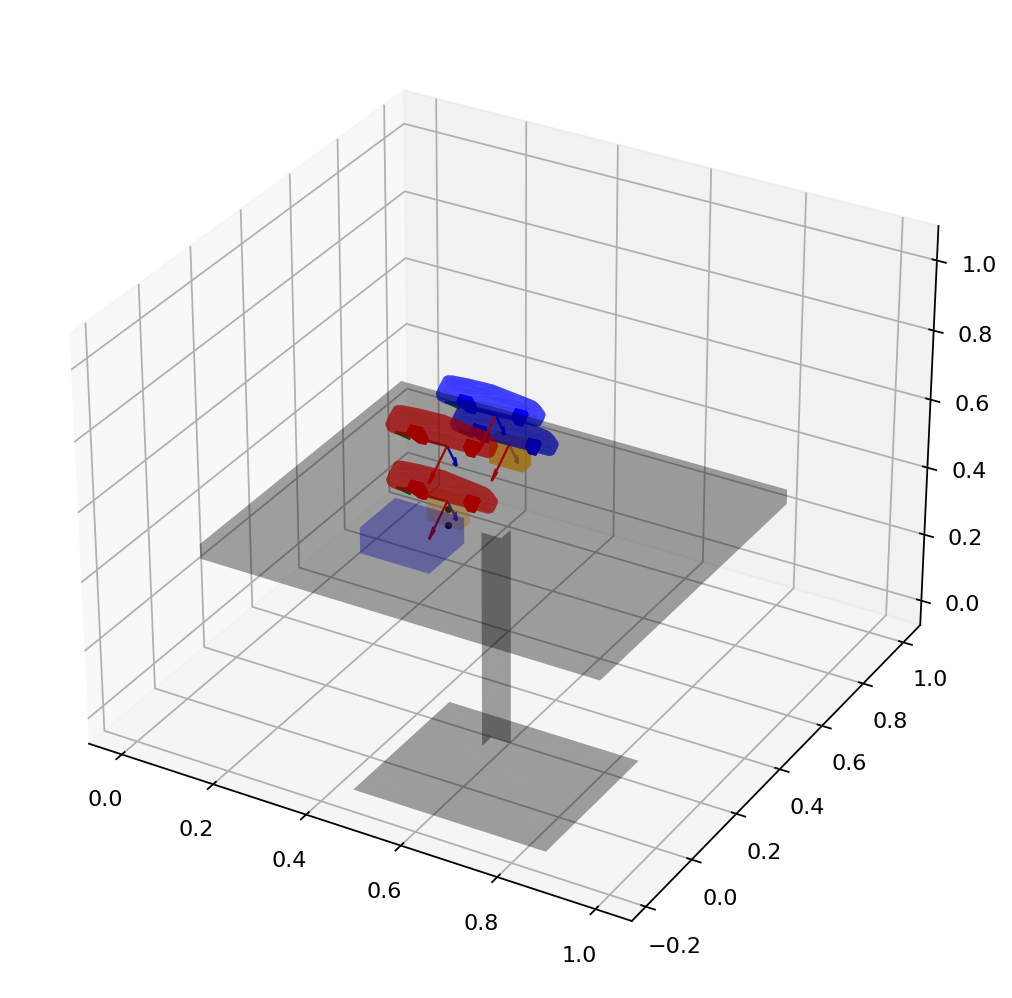

In [13]:
fig, ax = plt.init_3d_figure(figsize=(12,8), dpi=160)
plt.plot_mesh(ax=ax, mesh=obj_mesh1, A2B=obs_pos1.h_mat, alpha=0.5, color='orange')
plt.plot_mesh(ax=ax, mesh=obj_mesh2, A2B=obs_pos2.h_mat, alpha=0.2, color='blue')
plt.plot_mesh(ax=ax, mesh=obj_mesh3, A2B=obs_pos3.h_mat, alpha=0.2)

pre_grasp_gripper = grasp_man.get_gripper_transformed(pre_grasp_pose, is_tcp=False)
grasp_man.visualize_gripper(ax, pre_grasp_gripper, alpha=0.5, color='blue')
grasp_man.visualize_axis(ax, grasp_man.get_tcp_h_mat_from_eef(pre_grasp_pose), axis=[1,1,1], scale=0.1)

grasp_gripper = grasp_man.get_gripper_transformed(grasp_pose, is_tcp=False)
grasp_man.visualize_gripper(ax, grasp_gripper, alpha=0.5, color='blue')
grasp_man.visualize_axis(ax, grasp_man.get_tcp_h_mat_from_eef(grasp_pose), axis=[1,1,1], scale=0.1)

pre_release_gripper = grasp_man.get_gripper_transformed(grasp_man.pre_release_pose, is_tcp=False)
grasp_man.visualize_gripper(ax, pre_release_gripper, alpha=0.5, color='red')
grasp_man.visualize_axis(ax, grasp_man.get_tcp_h_mat_from_eef(pre_release_pose), axis=[1,1,1], scale=0.1)

release_gripper = grasp_man.get_gripper_transformed(release_pose, is_tcp=False)
grasp_man.visualize_gripper(ax, release_gripper, alpha=0.5, color='red')
grasp_man.visualize_axis(ax, grasp_man.get_tcp_h_mat_from_eef(release_pose), axis=[1,1,1], scale=0.1)

plt.plot_vertices(ax, grasp_man.obj_center_point)
plt.plot_vertices(ax, grasp_man.obj_support_point)
plt.plot_mesh(ax=ax, mesh=obj_mesh1, A2B=grasp_man.obj_post_release_pose, alpha=0.2, color='orange')